# Tavily + QuotientAI Reports: Complete Analysis Notebook

This notebook demonstrates how to:
1. Run queries through Tavily
2. Log all interactions to QuotientAI
3. Generate automatic Reports showing problem areas
4. Analyze results and identify improvement opportunities


### Install required packages

In [6]:
!pip install -q langchain langchain-openai langchain-tavily quotientai tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.1 MB/s eta 0:00:00


In [31]:
import json
import httpx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Any, Optional
import asyncio
import nest_asyncio
from tqdm.notebook import tqdm
from datetime import datetime
import os
from dotenv import load_dotenv
import time

In [3]:
nest_asyncio.apply()

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
%env TAVILY_API_KEY=your_tavily_api_key
%env QUOTIENT_API_KEY=your_quotient_api_key
%env OPENAI_API_KEY=your_openai_api_key

In [15]:
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
QUOTIENT_API_KEY = os.getenv("QUOTIENT_API_KEY")
APP_NAME = os.getenv("APP_NAME", "search-reports-experiment-02")
ENVIRONMENT = os.getenv("ENVIRONMENT", "production")

### Configure QuotientAI

In [16]:
from quotientai import QuotientAI, DetectionType

# Initialize QuotientAI client
quotient = QuotientAI(api_key=QUOTIENT_API_KEY)

# Configure logger for the experiment
quotient.logger.init(
    app_name=APP_NAME,
    environment=ENVIRONMENT,
    detections=[
        DetectionType.HALLUCINATION,
        DetectionType.DOCUMENT_RELEVANCY
    ],
    detection_sample_rate=1.0,  # Log 100% for this experiment
    tags={
        "experiment": "reports-visualize-2025",
        "version": "v1"
    }
)

## Load Dataset from JSONL

In [8]:
def load_queries_from_jsonl(filepath: str) -> pd.DataFrame:
    """
    Load queries from JSONL file

    Expected format:
    {"id": "technology-014", "domain": "technology", "query": "What changed in Android 15?"}
    """
    queries = []

    with open(filepath, 'r') as f:
        for line in f:
            if line.strip():  # Skip empty lines
                queries.append(json.loads(line))

    df = pd.DataFrame(queries)
    print(f"Loaded {len(df)} queries from {filepath}")
    print(f"\nDomain distribution:", df['domain'].value_counts().to_string())

    return df

# Load the dataset
queries_df = load_queries_from_jsonl('fireplexity_queries.jsonl')
queries_df = queries_df.sample(frac=1, random_state=42).reset_index(drop=True)
queries_df.head()

Loaded 150 queries from fireplexity_queries.jsonl

Domain distribution: domain
finance          30
science          30
technology       30
entertainment    30
news             30


,id,domain,query
0,technology-014,technology,Compare PostgreSQL extensions for vector searc...
1,finance-019,finance,What are Meta’s primary legal and regulatory r...
2,entertainment-029,entertainment,Which directors are known for frequent Christo...
3,technology-019,technology,What ranking strategies help retrieval quality...
4,technology-017,technology,How to design guardrails for personally identi...


### Analyze dataset distribution

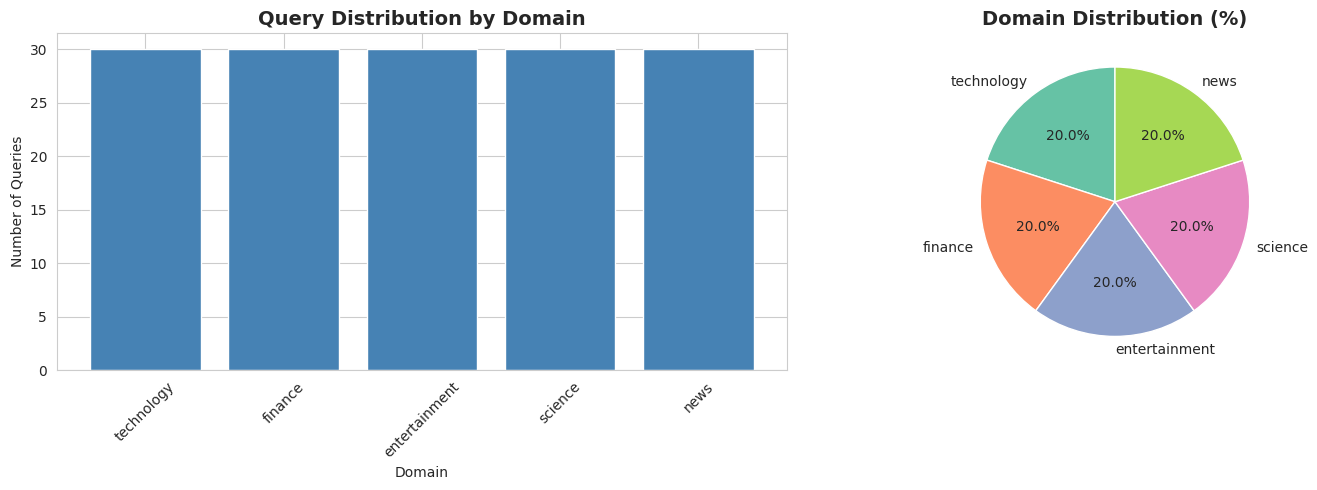


Total queries: 150
Unique domains: 5


In [9]:
# Visualize domain distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
domain_counts = queries_df['domain'].value_counts()
axes[0].bar(domain_counts.index, domain_counts.values, color='steelblue')
axes[0].set_title('Query Distribution by Domain', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Domain')
axes[0].set_ylabel('Number of Queries')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(domain_counts.values, labels=domain_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette("Set2"))
axes[1].set_title('Domain Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal queries: {len(queries_df)}")
print(f"Unique domains: {queries_df['domain'].nunique()}")

## Create Agent to generate answers from retrieved search data

In [11]:
# LangChain / tools
from langchain_openai import ChatOpenAI
from langchain.agents import create_openai_tools_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_tavily import TavilySearch, TavilyExtract
from langchain.schema import HumanMessage

In [12]:
llm: Optional[ChatOpenAI] = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

In [33]:
def build_agent() -> AgentExecutor:
    """Create a generic research agent with Tavily tools and a memo-style prompt."""
    # Tools
    tavily_search = TavilySearch(
        max_results=5,
        search_depth="advanced",
        # Keep broad by default; you can restrict per domain later
    )
    # tavily_extract = TavilyExtract()

    tools = [tavily_search]

    today = datetime.now().strftime("%B %d, %Y")
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a careful research assistant.

PROCESS:
1) Use web search to find high-quality sources.
2) Extract content from the most relevant pages.
3) Draft a short memo grounded in retrieved content.

FORMAT:
Date: {today}
Question: {{question}}

Answer:
- Keep it concise and factual
- Cite sources inline like [1], [2] from the list you retrieved
- If context is insufficient, say what is missing
"""),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ])

    agent = create_openai_tools_agent(llm=llm, tools=tools, prompt=prompt)
    return AgentExecutor(agent=agent, tools=tools, return_intermediate_steps=True, verbose=False)


def extract_documents_from_response(response: Dict[str, Any]) -> List[Dict[str, str]]:
    """Extract documents from agent response for Quotient logging"""

    documents = []

    for step in response.get("intermediate_steps", []):
        tool_call, tool_output = step
        tool_name = getattr(tool_call, "tool", "")

        # Handle TavilySearch - snippets
        for result in tool_output.get('results', []):
            doc = {
                "page_content": result.get('content', ''),
                "metadata": {"source": result.get('url', '')}
            }
            documents.append(doc)

    return documents


## Run user query to do web search using Tavily

In [34]:
def run_one_query(agent: Optional[AgentExecutor], row: Dict[str, Any]):
    """
    Execute one query through the agent then log run to Quotient.
    """

    start_time = datetime.now()

    qid = row.get("id", "")
    domain = row.get("domain", "")
    question = row.get("query", "")
    if not question:
        return {"id": qid, "error": "empty query"}

    # Run the agent
    resp = agent.invoke({
            "messages": [HumanMessage(content=question)],
            "question": question
        })
    # Extract results
    answer = resp.get("output", "").strip()
    docs = extract_documents_from_response(resp)

    # Log to Quotient for monitoring
    log_id = quotient.log(
        user_query=question,
        model_output=answer,
        documents=docs,
        tags={"domain": domain}
    )

    try:
        detection_result = quotient.poll_for_detection(log_id=log_id, timeout_seconds=10)
    except Exception:
        pass

    # Compile results
    duration = (datetime.now() - start_time).total_seconds()


    return {
        "id": qid,
        "domain": domain,
        "query": question,
        "answer_preview": answer[:280],
        "doc_count": len(docs),
        "log_id": log_id
    }

In [38]:
agent = build_agent()

results: List[Dict[str, Any]] = []
print(f"Starting batch with {100} queries...")

for i, (_, row) in enumerate(tqdm(queries_df.iterrows(),
                                  total=len(queries_df),
                                  desc=f"Running")):
    out = run_one_query(agent, row.to_dict())
    results.append(out)
    time.sleep(0.2)

Starting batch with 100 queries...


Running:   0%|          | 0/126 [00:00<?, ?it/s]

In [39]:
len(results)

126

In [40]:
results[-1]

{'id': 'entertainment-013',
 'domain': 'entertainment',
 'query': 'Who composed the score for The Lord of the Rings films and what motifs stand out?',
 'answer_preview': 'Date: October 27, 2025  \nQuestion: Who composed the score for The Lord of the Rings films and what motifs stand out?\n\nAnswer:  \nThe score for The Lord of the Rings films was composed by Howard Shore. His work is notable for its use of **leitmotifs**, which are recurring musical t',
 'doc_count': 5,
 'log_id': 'bc8cbfff-b917-412b-ac65-f62226b55f78'}